In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [22]:
file_path = "/home/jobsr/Documents/GitHub/iesb_deeplearning/rnn/timeseries/data/CITIMON.csv"

try:
    # Carregar o CSV
    df = pd.read_csv(file_path, parse_dates=True, index_col=0)
    print("CSV carregado")
    print(f"Colunas disponíveis: {df.columns.tolist()}")
    print(df.head())

except FileNotFoundError:
    print(f"Erro: O arquivo '{file_path}' não foi encontrado.")
    exit()

CSV carregado
Colunas disponíveis: ['CCIUAC', 'CCIUTC', 'CONB', 'CONQ', 'EEC', 'EEGP', 'EXVUS', 'FM1', 'FM1D82', 'FSPCAP', 'FSPCOM', 'FSPCON', 'IP', 'LHUR', 'LUINC', 'PW', 'RCARD', 'RTRR']
             CCIUAC    CCIUTC     CONB     CONQ    EEC   EEGP  EXVUS  \
DATE                                                                   
1980-01-01  67166.0  153636.0  48579.0  66820.0  7.403  111.0  85.52   
1980-02-01  67119.0  153308.0  47759.0  64049.0  6.962  118.6  86.37   
1980-03-01  66786.0  152347.0  46705.0  64831.0  6.848  123.0  90.26   
1980-04-01  65837.0  150937.0  45835.0  63913.0  5.986  124.2  91.09   
1980-05-01  65035.0  149238.0  46819.0  64598.0  5.837  124.4  86.96   

                   FM1      FM1D82  FSPCAP  FSPCOM  FSPCON    IP  LHUR  LUINC  \
DATE                                                                            
1980-01-01  386.099999  477.799999  126.68  110.87   85.09  85.9   6.3  416.0   
1980-02-01  389.799999  476.500000  131.27  115.34   83.14  86.

/tmp/ipykernel_15098/1790799939.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file_path, parse_dates=True, index_col=0)


In [23]:
# Definir output
target_column = 'CONB'

# Definir input (features)
input_columns = ['CONB', 'CCIUTC', 'EEC', 'EEGP', 'EXVUS', 'FM1', 'FM1D82'] 

missing_columns = [col for col in input_columns if col not in df.columns]
if missing_columns:
    print(f"Erro: As seguintes colunas de input não foram encontradas no CSV: {missing_columns}")
    print("Por favor, verifique os nomes das colunas em seu 'CITIMON.csv'.")
    exit()

if target_column not in df.columns:
    print(f"Erro: A coluna alvo '{target_column}' não foi encontrada no CSV.")
    exit()

In [24]:
# Selecionar apenas as colunas relevantes
df_selected = df[input_columns]

# Tratamento de dados ausentes (se houver)
# Para múltiplas colunas, usar dropna() pode remover muitas linhas.
# A interpolação ou preenchimento com valores apropriados é geralmente melhor.
# Para este exemplo, faremos interpolação coluna por coluna.
print("\nVerificando e tratando valores NaN nas colunas selecionadas...")
for col in df_selected.columns:
    if df_selected[col].isnull().any():
        print(f"Detectados valores NaN na coluna '{col}'. Realizando interpolação linear.")
        df_selected[col] = df_selected[col].interpolate(method='linear')

# Se ainda houver NaNs (ex: no início da série antes do primeiro valor válido), preencher com 0 ou média
df_selected = df_selected.fillna(0) # Ou df_selected.fillna(df_selected.mean())


Verificando e tratando valores NaN nas colunas selecionadas...
Detectados valores NaN na coluna 'CONB'. Realizando interpolação linear.
Detectados valores NaN na coluna 'CCIUTC'. Realizando interpolação linear.
Detectados valores NaN na coluna 'EEC'. Realizando interpolação linear.
Detectados valores NaN na coluna 'EEGP'. Realizando interpolação linear.
Detectados valores NaN na coluna 'FM1'. Realizando interpolação linear.
Detectados valores NaN na coluna 'FM1D82'. Realizando interpolação linear.


/tmp/ipykernel_15098/3800542314.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected[col] = df_selected[col].interpolate(method='linear')


In [25]:
# Normalização dos dados: importante para RNNs com múltiplas features
# Cada coluna será escalonada independentemente para o mesmo range.
scaler = MinMaxScaler(feature_range=(-1, 1))
# Fit e Transform em todo o DataFrame selecionado
data_scaled = scaler.fit_transform(df_selected)

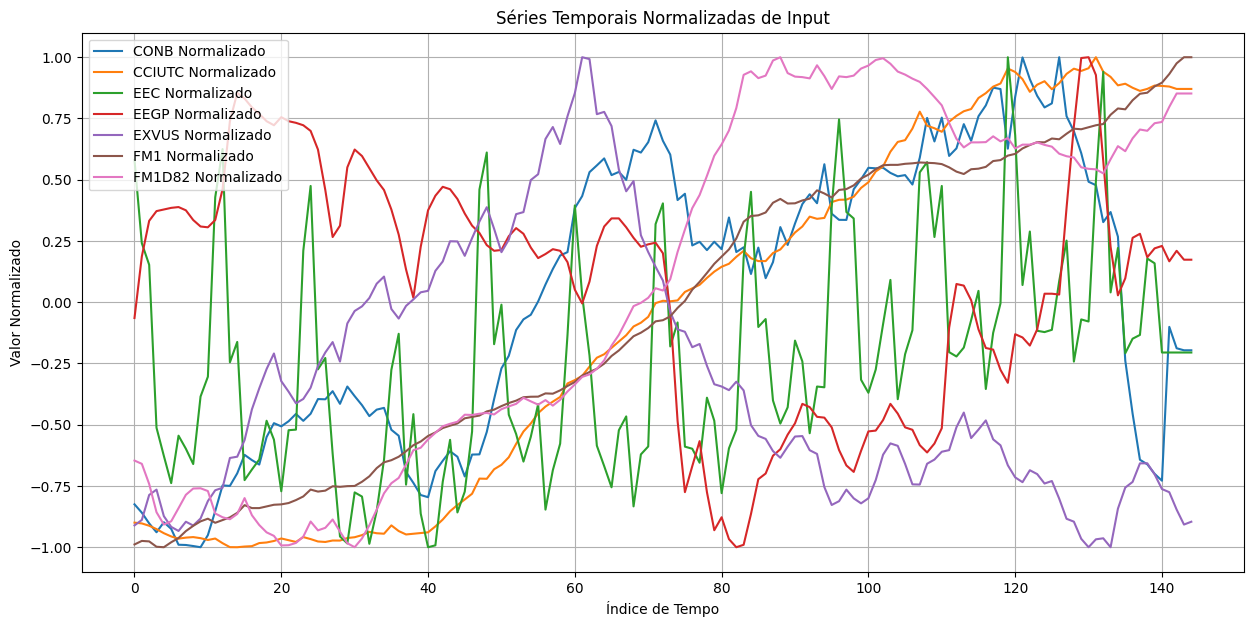

In [26]:
plt.figure(figsize=(15, 7))
for i, col in enumerate(input_columns):
    plt.plot(data_scaled[:, i], label=f'{col} Normalizado')
plt.title("Séries Temporais Normalizadas de Input")
plt.xlabel("Índice de Tempo")
plt.ylabel("Valor Normalizado")
plt.legend()
plt.grid(True)
plt.show()

In [27]:
# Extrair a série alvo (CONB) após o escalonamento, para o 'y'
# Precisamos do scaler para a coluna CONB para inverter a transformação depois
# Criamos um scaler separado para a coluna CONB, pois ela é o OUTPUT
scaler_target = MinMaxScaler(feature_range=(-1, 1))
target_series_scaled = scaler_target.fit_transform(df[target_column].values.reshape(-1, 1))

In [28]:
# 2. Preparação dos Dados para Treinamento
# A função create_dataset agora precisa lidar com um array 2D para X
def create_dataset_multi_feature(data, target_series, input_sequence_length):
    X, y = [], []
    # data: array numpy 2D (num_samples, num_features)
    # target_series: array numpy 1D (num_samples,) ou 2D (num_samples, 1)
    
    for i in range(len(data) - input_sequence_length):
        X.append(data[i : i + input_sequence_length, :]) # Pega todas as features na sequência
        y.append(target_series[i + input_sequence_length]) # Pega o próximo valor da série alvo
    return np.array(X), np.array(y)

input_sequence_length = 30 # Mantenha ou ajuste
X_np, y_np = create_dataset_multi_feature(data_scaled, target_series_scaled, input_sequence_length)

# Convertendo para tensores PyTorch
# X_tensor shape: (número_de_amostras, comprimento_da_sequência, número_de_features)
# y_tensor shape: (número_de_amostras, 1)
X_tensor = torch.from_numpy(X_np).float()
y_tensor = torch.from_numpy(y_np).float()

print(f"Formato de X_tensor (multi-feature): {X_tensor.shape}")
print(f"Formato de y_tensor: {y_tensor.shape}")

Formato de X_tensor (multi-feature): torch.Size([115, 30, 7])
Formato de y_tensor: torch.Size([115, 1])


In [29]:
# 3. Definição da Arquitetura da RNN
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Agora o input_size é o número de features (colunas) que estamos usando
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, hn = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

In [30]:
# Parâmetros da RNN
input_size = len(input_columns) # ESSA É A MUDANÇA CRÍTICA AQUI!
hidden_size = 128     # Aumentei para 128, mais features podem precisar de mais complexidade
output_size = 1
num_layers = 2

In [32]:
# Dividir em treino e teste (mantendo 80/20)
train_size = int(len(X_tensor) * 0.8)
X_train, X_test = X_tensor[:train_size], X_tensor[train_size:]
y_train, y_test = y_tensor[:train_size], y_tensor[train_size:]

In [33]:
# Instanciando o modelo
model = SimpleRNN(input_size, hidden_size, output_size, num_layers)

# Definindo a função de perda e o otimizador
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Ajustei o learning rate novamente

# 4. Treinamento do Modelo
num_epochs = 500 # Aumentei o número de épocas para 500
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    optimizer.zero_grad()
    loss.backward()
    
    # Clipagem de gradiente: Considere usar se o treinamento for instável
    # nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
    optimizer.step()
    
    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

print("Treinamento concluído!")

Epoch [50/500], Loss: 0.006584
Epoch [100/500], Loss: 0.004619
Epoch [150/500], Loss: 0.003769
Epoch [200/500], Loss: 0.003383
Epoch [250/500], Loss: 0.002935
Epoch [300/500], Loss: 0.002613
Epoch [350/500], Loss: 0.002255
Epoch [400/500], Loss: 0.001887
Epoch [450/500], Loss: 0.001529
Epoch [500/500], Loss: 0.001515
Treinamento concluído!


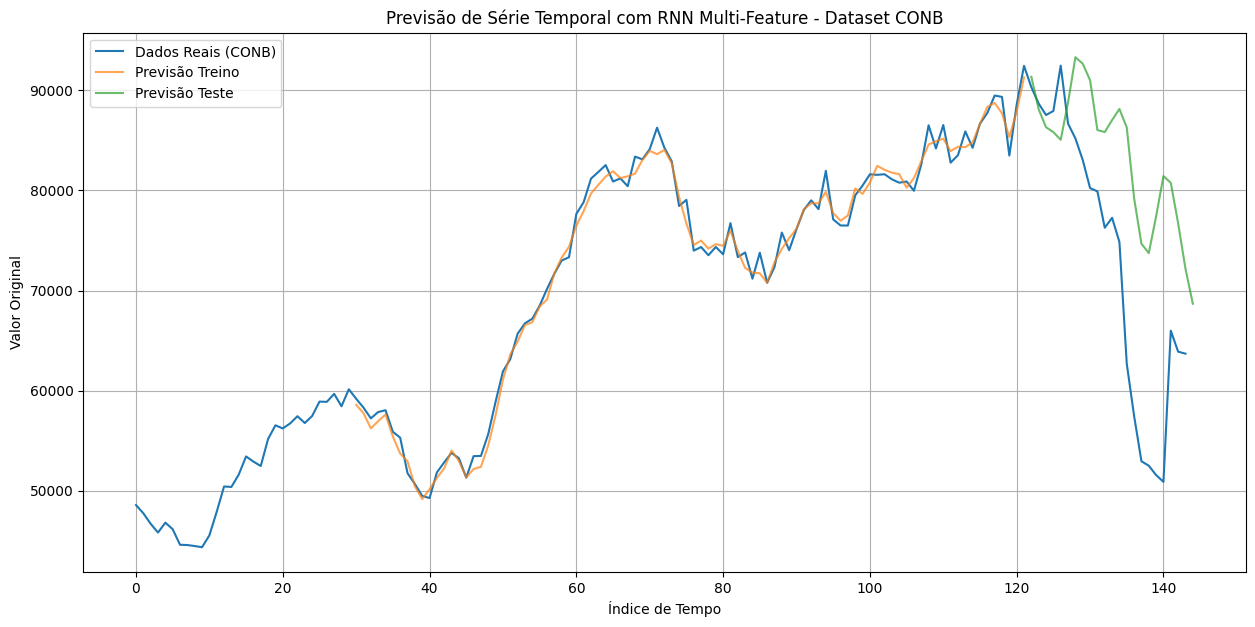

In [34]:
# 5. Avaliação e Previsão
model.eval()
with torch.no_grad():
    train_predict_scaled = model(X_train).numpy()
    test_predict_scaled = model(X_test).numpy()

# Inverter a normalização para plotar os resultados na escala original
# Use o scaler_target para inverter a transformação da coluna alvo
train_predict = scaler_target.inverse_transform(train_predict_scaled)
y_train_original = scaler_target.inverse_transform(y_train.numpy())

test_predict = scaler_target.inverse_transform(test_predict_scaled)
y_test_original = scaler_target.inverse_transform(y_test.numpy())

# Para a plotagem, precisamos da série CONB original (não a escalonada)
# Que já foi carregada no início como parte do df[target_column]
full_series_original = df[target_column].values.astype(float) # Garante que seja float

# Alinhar as previsões com os dados originais no tempo
train_plot = np.empty_like(full_series_original)
train_plot[:] = np.nan
train_plot[input_sequence_length : len(train_predict) + input_sequence_length] = train_predict.flatten()

test_plot = np.empty_like(full_series_original)
test_plot[:] = np.nan
test_plot[len(train_predict) + input_sequence_length : len(train_predict) + input_sequence_length + len(test_predict)] = test_predict.flatten()


# Plotando os resultados
plt.figure(figsize=(15, 7))
plt.plot(full_series_original, label=f'Dados Reais ({target_column})')
plt.plot(train_plot, label='Previsão Treino', alpha=0.7)
plt.plot(test_plot, label='Previsão Teste', alpha=0.7)
plt.title(f"Previsão de Série Temporal com RNN Multi-Feature - Dataset {target_column}")
plt.xlabel("Índice de Tempo")
plt.ylabel("Valor Original")
plt.legend()
plt.grid(True)
plt.show()